In [1]:
from functional.backtester import Backtester as b
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.sec import SEC
from database.adatabase import ADatabase
from modeler_strats.universal_modeler import UniversalModeler
from transformer.adhoc_transforms import Adhoc as adhocs
from transformer.risk_transforms import Risk as risks
from transformer.analysis_transforms import Analysis as anas

import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from statistics import variance
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm

In [2]:
start_date = datetime(2023,1,1)
end_date = datetime.now()

In [3]:
market = Market()
sec = SEC()
fin_db = ADatabase("financial")
earnings_db = ADatabase("earnings")
dividends_db = ADatabase("dividends")
speculation_db = ADatabase("spec")
classification_db = ADatabase("spec_classification")
current_db = ADatabase("financial_current")
umod = UniversalModeler()

In [4]:
tyields = adhocs.tyields()
bench_returns = adhocs.spy_bench()

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
sp500 = sp500.rename(columns={"Symbol":"ticker"})
market.disconnect()

In [6]:
financial_factors = ['assets',
 'liabilitiesandstockholdersequity',
 'incometaxexpensebenefit',
 'retainedearningsaccumulateddeficit',
 'accumulatedothercomprehensiveincomelossnetoftax',
 'earningspersharebasic',
 'earningspersharediluted',
 'propertyplantandequipmentnet',
 'cashandcashequivalentsatcarryingvalue',
 'entitycommonstocksharesoutstanding',
 'weightedaveragenumberofdilutedsharesoutstanding',
 'weightedaveragenumberofsharesoutstandingbasic',
 'stockholdersequity']

In [7]:
dividend_factors = ['assets',
 'liabilitiesandstockholdersequity',
 'incometaxexpensebenefit',
 'retainedearningsaccumulateddeficit',
 'accumulatedothercomprehensiveincomelossnetoftax',
 'earningspersharebasic',
 'earningspersharediluted',
 'propertyplantandequipmentnet',
 'cashandcashequivalentsatcarryingvalue',
 'entitycommonstocksharesoutstanding',
 'weightedaveragenumberofdilutedsharesoutstanding',
 'weightedaveragenumberofsharesoutstandingbasic',
 'stockholdersequity',
"commonstockdividendspersharecashpaid"]

In [8]:
classification_factors = []
classification_factors.append("d1")
classification_factors.append("d2")
classification_factors.append("d3")
classification_factors.append("rolling14")

In [9]:
factors = [str(x) for x in range(14)]

In [10]:
included_columns=[
    "year",
    "quarter",
    "week",
    "ticker",
    "adjclose",
    "y"
]
included_columns.extend(factors)
included_columns.extend(classification_factors)
included_columns.extend(financial_factors)
included_columns.extend(dividend_factors)
included_columns = list(set(included_columns))

In [11]:
new_prices = []
market.connect()
sec.connect()
for ticker in tqdm(sp500["ticker"].unique()[:10]):
    try:
        cik = int(sp500[sp500["ticker"]==ticker]["CIK"])
        financials = sec.retrieve_filing_data(cik)
        ticker_sim = market.retrieve_ticker_prices("prices",ticker)
        completed = risks.backtesting_risk_prep(ticker_sim,bench_returns,financials)
        new_prices.append(completed)
    except:
        continue
sec.disconnect()
market.disconnect()
price_returns = pd.concat(new_prices)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.25it/s]


In [12]:
trades = []
reqs = [0.05]
signals = [0.05]
values = [True]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [False]
parameters = []
positions = 10
training_year = 4
strats = ["earnings","dividends","financial","sector"]
for strat in strats:
    for value in values:
        for classification in classifications:
            for ceiling in ceilings:
                for floor in floors:
                    for hedge in hedges:
                        for signal in signals:
                            for req in reqs:
                                parameter = {
                                            "value":value
                                             ,"classification":classification
                                             ,"ceiling":ceiling
                                             ,"floor":floor
                                             ,"hedge":hedge
                                             ,"signal":signal
                                             ,"req":req
                                             ,"training_years":training_year
                                            ,"strat":strat
                                            }
                                parameters.append(parameter)

In [13]:
training_sets = []
sec.connect()
market.connect()
for ticker in tqdm(sp500["ticker"].unique()[:10]):
    try:
        cik = int(sp500[sp500["ticker"]==ticker]["CIK"])
        prices = market.retrieve_ticker_prices("prices",ticker)
        prices = p.column_date_processing(prices)
        prices["year"] = [x.year for x in prices["date"]]
        prices["quarter"] = [x.quarter for x in prices["date"]]
        filing = sec.retrieve_filing_data(cik)
        filing = p.column_date_processing(filing)
        filing = filing.groupby(["year","quarter"]).mean().reset_index()
        filing["year"] = filing["year"] + 1
        if "commonstockdividendspersharecashpaid" in filing.columns:
            filing["commonstockdividendspersharecashpaid"] = filing["commonstockdividendspersharecashpaid"].fillna(0)
        else:
            filing["commonstockdividendspersharecashpaid"] = 0
        ticker_data = prices[prices["ticker"]==ticker]
        ticker_data.sort_values("date",ascending=True,inplace=True)
        ticker_data["adjclose"] = [float(x) for x in ticker_data["adjclose"]]
        ticker_data = ticker_data.groupby(["year","week"]).mean().reset_index()
        for i in range(14):
            ticker_data[str(i)] = ticker_data["adjclose"].shift(i)
        ticker_data["d1"] = ticker_data["adjclose"].pct_change(periods=1)
        ticker_data["d2"] = ticker_data["d1"].pct_change(periods=1)
        ticker_data["d3"] = ticker_data["d2"].pct_change(periods=1)
        ticker_data["rolling14"] = ticker_data["adjclose"].rolling(window=14).mean()
        ticker_data.dropna(inplace=True)
        ticker_data["ticker"] = ticker
        ticker_data["y"] = ticker_data["adjclose"].shift(-1)
        ticker_data = ticker_data.merge(filing,on=["year","quarter"],how="left").reset_index()
        ticker_data = ticker_data[included_columns]
        training_sets.append(ticker_data)
    except Exception as e:
        print(str(e))
        continue
sec.disconnect()
market.disconnect()
data = pd.concat(training_sets)

 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6/10 [00:01<00:01,  3.83it/s]

"['entitycommonstocksharesoutstanding'] not in index"


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8/10 [00:02<00:00,  2.91it/s]

"['stockholdersequity'] not in index"


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.12it/s]


In [14]:
market.connect()
sp500 = market.retrieve("sp500")
sp500 = sp500.rename(columns={"Symbol":"ticker"})
market.disconnect()

In [15]:
prediction_slice = data[data["year"]>=start_date.year-2].copy().reset_index(drop=True)
prediction_slice_quarterly = prediction_slice.copy().groupby(["year","quarter","ticker"]).mean().reset_index()

In [16]:
data.sort_values(["year","quarter","week"])[["year","quarter","week"]]

,year,quarter,week
0,2000,2.0,14
0,2000,2.0,14
0,2000,2.0,14
0,2000,2.0,14
0,2000,2.0,14
...,...,...,...
1207,2023,2.0,21
529,2023,2.0,21
1207,2023,2.0,21
1207,2023,2.0,21


In [17]:
speculation_db.connect()
models = speculation_db.retrieve("models")
speculation_db.disconnect()

In [18]:
fin_db.connect()
financial_models = fin_db.retrieve("models")
fin_db.disconnect()

In [19]:
earnings_db.connect()
earnings_models = earnings_db.retrieve("models")
earnings_db.disconnect()

In [20]:
dividends_db.connect()
dividends_models = dividends_db.retrieve("models")
dividends_db.disconnect()

In [21]:
classification_db.connect()
classification_models = classification_db.retrieve("models")
classification_db.disconnect()

In [22]:
simulation = umod.recommend(models,prediction_slice.copy(),factors)
simulation["week"] = simulation["week"] + 1
simulation["prediction"] = (simulation["cat_prediction"] + simulation["xgb_prediction"] + simulation["tf_prediction"]) / 3

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-03 11:17:12         2522
metadata.json                                  2023-03-03 11:17:12           64
variables.h5                                   2023-03-03 11:17:12        84160
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_absolute_percentage_error
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
31/31 [==============================] - 0s 600us/step


In [23]:
classification_simulation = umod.recommend(classification_models,prediction_slice.copy(),classification_factors)
classification_simulation["week"] = classification_simulation["week"] + 1
classification_simulation["classification_prediction"] = ((classification_simulation["cat_prediction"] + \
                                                          classification_simulation["xgb_prediction"] + \
                                                          classification_simulation["tf_prediction"]) / 3) > 0.5
classification_simulation["classification_prediction"] = [int(x) for x in classification_simulation["classification_prediction"]]

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-15 09:46:40         2141
metadata.json                                  2023-03-15 09:46:40           64
variables.h5                                   2023-03-15 09:46:40        23208
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
31/31 [==============================] - 0s 633us/step


In [24]:
financial_simulation = umod.recommend(financial_models,prediction_slice_quarterly.copy(),financial_factors)
financial_simulation["financial_prediction"] = (financial_simulation["cat_prediction"] + financial_simulation["xgb_prediction"]) / 2

In [25]:
earnings_simulation = umod.recommend(earnings_models,prediction_slice_quarterly.copy(),financial_factors)
earnings_simulation["earnings_prediction"] = (earnings_simulation["cat_prediction"] + earnings_simulation["xgb_prediction"]) / 2

In [26]:
dividends_simulation = umod.recommend(dividends_models,prediction_slice_quarterly.copy(),dividend_factors)
dividends_simulation["dividends_prediction"] = (dividends_simulation["cat_prediction"] + dividends_simulation["xgb_prediction"]) / 2

In [27]:
sim = price_returns.merge(simulation.drop("adjclose",axis=1)[["year","week","ticker","prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(classification_simulation.drop(["adjclose","training_years"],axis=1,errors="ignore")[["year","week","ticker","classification_prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(tyields[["date","weekly_yield","quarterly_yield"]],on="date",how="left") \
                    .merge(financial_simulation[["year","quarter","ticker","financial_prediction"]],on=["year","quarter","ticker"],how="left") \
                    .merge(earnings_simulation[["year","quarter","ticker","earnings_prediction"]],on=["year","quarter","ticker"],how="left") \
                    .merge(dividends_simulation[["year","quarter","ticker","dividends_prediction"]],on=["year","quarter","ticker"],how="left")

In [28]:
ranks = sim.merge(sp500[["ticker","GICS Sector"]],how="left").groupby(["year","quarter","GICS Sector"]).mean().reset_index().sort_values(["year","quarter","return_4"],ascending=False).groupby(["year","quarter"]).first().reset_index().rename(columns={"GICS Sector":"top_sector"})[["year","quarter","top_sector"]]
ranks["year"] = ranks["year"] + 1

In [29]:
price_returns

,date,close,high,low,open,volume,adjclose,adjhigh,adjlow,adjopen,...,day,weekly_return,bench_return,variance,bench_quarterly_return,quarterly_variance,market_cov,market_quarterly_cov,beta,quarterly_beta
15914,2013-01-03,94.67,94.929,94.13,94.34,2704600,69.784976,69.975895,69.386921,69.54172,...,3,0.010905,-0.005314,0.000032,-0.007489,0.000015,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
15915,2013-01-03,94.67,94.929,94.13,94.34,2704600,69.784976,69.975895,69.386921,69.54172,...,3,0.014661,-0.002187,0.000038,-0.002187,0.000023,7.089861e-07,0.000000e+00,1.857466e-02,0.000000e+00
15916,2013-01-03,94.67,94.929,94.13,94.34,2704600,69.784976,69.975895,69.386921,69.54172,...,3,0.014661,-0.005314,0.000032,-0.007489,0.000015,0.000000e+00,-4.517509e-21,0.000000e+00,-2.961108e-16
15917,2013-01-03,94.67,94.929,94.13,94.34,2704600,69.784976,69.975895,69.386921,69.54172,...,3,-0.018681,-0.002187,0.000038,-0.002187,0.000023,-3.558908e-06,0.000000e+00,-9.323952e-02,0.000000e+00
15918,2013-01-03,94.67,94.929,94.13,94.34,2704600,69.784976,69.975895,69.386921,69.54172,...,3,-0.018681,-0.005314,0.000032,-0.007489,0.000015,-2.736568e-21,-4.517509e-21,-8.673129e-17,-2.961108e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75105,2023-05-19,216.18,217.540,215.26,216.64,1504194,216.180000,217.540000,215.260000,216.64000,...,4,0.000557,-0.000267,0.000046,-0.017594,0.000052,5.856255e-19,9.473216e-18,1.280781e-14,1.816226e-13
75106,2023-05-19,216.18,217.540,215.26,216.64,1504194,216.180000,217.540000,215.260000,216.64000,...,4,-0.010084,0.004405,0.000057,-0.017333,0.000052,-3.969723e-06,9.468699e-18,-6.988883e-02,1.829616e-13
75107,2023-05-19,216.18,217.540,215.26,216.64,1504194,216.180000,217.540000,215.260000,216.64000,...,4,-0.010084,-0.000267,0.000046,-0.017594,0.000052,5.755915e-19,9.473216e-18,1.258837e-14,1.816226e-13
75108,2023-05-19,216.18,217.540,215.26,216.64,1504194,216.180000,217.540000,215.260000,216.64000,...,4,-0.028310,0.004405,0.000057,-0.017333,0.000052,-5.186274e-06,9.473216e-18,-9.130676e-02,1.830489e-13


In [30]:
sim = risks.required_returns(sim)
sim = sim.groupby(["date","ticker","classification_prediction"]).mean().reset_index()
sim.sort_values("date",inplace=True)
sim = sim.groupby(["date","ticker"]).mean().reset_index()
sim.sort_values("date",inplace=True)

In [31]:
dividend_tickers = adhocs.dividend_tickers(price_returns)

In [32]:
current_db.connect()
current_db.drop("trades")
for parameter in tqdm(parameters):
    simulation = sim.copy()
    strat = parameter["strat"]
    simulation = risks.strat_specific(strat,simulation,dividend_tickers,sp500,ranks)
    b.experimental_backtest(simulation.copy(),parameter,start_date,end_date,current_db)
current_db.disconnect()

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 28/32 [00:01<00:00, 18.70it/s]

financial_current trades documents must be a non-empty list
financial_current trades documents must be a non-empty list
financial_current trades documents must be a non-empty list


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 18.28it/s]

financial_current trades documents must be a non-empty list


In [33]:
current_db.connect()
t = current_db.retrieve("trades")
current_db.disconnect()

In [34]:
t = t.fillna(1)

In [35]:
analysis = []
for parameter in parameters:
    try:
        indexer = list(parameter.keys())
        ledger = t.sort_values(["year","week"])
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        break
        continue
a = pd.DataFrame(analysis)

In [36]:
a.sort_values("pv",ascending=False)

,value,classification,ceiling,floor,hedge,signal,req,training_years,strat,pv,beta,rrr,sharpe
13,True,True,False,True,False,0.05,0.05,4,financial,1.014855,-0.107306,NaN,0.349890
13,True,True,False,False,False,0.05,0.05,4,financial,1.012381,-0.110071,NaN,0.363571
8,True,True,True,True,False,0.05,0.05,4,financial,1.012261,-0.271146,NaN,0.148036
14,True,False,False,True,False,0.05,0.05,4,financial,1.012088,-0.125294,NaN,0.321740
14,True,False,False,False,False,0.05,0.05,4,financial,1.009606,-0.125440,NaN,0.341154
8,True,True,True,False,False,0.05,0.05,4,financial,1.009367,-0.269547,NaN,0.159649
10,True,False,True,True,False,0.05,0.05,4,financial,1.008942,-0.234089,NaN,0.185650
10,True,False,True,False,False,0.05,0.05,4,financial,1.006138,-0.226724,NaN,0.204045
6,True,True,False,True,False,0.05,0.05,4,dividends,1.001000,5.991162,0.860961,-0.008579
6,True,True,False,False,False,0.05,0.05,4,dividends,1.001000,5.991162,0.860961,-0.008579


In [37]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,classification,ceiling,floor,hedge,signal,req,training_years,pv,beta,rrr,sharpe
3,sector,True,True,False,True,False,0.05,0.05,4,0.999565,-4.012347,1.099316,0.013168
1,earnings,True,True,True,False,False,0.05,0.05,4,1.000624,7.661531,0.574076,-0.006758
0,dividends,True,True,False,True,False,0.05,0.05,4,1.001000,5.991162,0.860961,-0.008579
2,financial,True,True,False,True,False,0.05,0.05,4,1.014855,-0.107306,NaN,0.349890


In [38]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t.copy()
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [39]:
t.columns

Index(['year', 'week', 'ticker', 'delta_sign', 'quarterly_delta', 'delta',
       'returns', 'floored_returns', 'position', 'actual_returns', 'value',
       'classification', 'ceiling', 'floor', 'hedge', 'signal', 'req',
       'training_years', 'strat'],
      dtype='object')

In [40]:
portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
counted_columns = [x for x in range(ledger["position"].max()+1)]
for col in range(positions):
    if col not in counted_columns:
        portfolio[col] = 1
portfolio.reset_index()

position,index,year,week,0,1,2,3,4,5,6,7,8,9
0,0,2023.0,2.0,0.971520,0.962078,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
1,1,2023.0,4.0,1.076730,1.022927,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
2,2,2023.0,6.0,0.998016,0.965801,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
3,3,2023.0,10.0,0.971706,0.978945,0.969794,1.000000,1.000000,1.000000,1.000000,1,1,1
4,4,2023.0,11.0,1.074431,1.002335,0.998268,0.984373,0.998736,0.970213,1.002405,1,1,1
5,5,2023.0,12.0,0.992027,1.002848,1.058182,1.000000,1.000000,1.000000,1.000000,1,1,1
6,6,2023.0,13.0,0.985299,1.033124,1.039598,0.985326,1.000000,1.000000,1.000000,1,1,1
7,7,2023.0,14.0,1.005469,1.000841,0.995653,0.990612,1.004988,1.000000,1.000000,1,1,1
8,8,2023.0,15.0,1.011572,1.002277,0.989590,1.000000,1.000000,1.000000,1.000000,1,1,1
9,9,2023.0,16.0,1.017670,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1


In [41]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = adhocs.spy_bench()
bench = bench.fillna(method="bfill").dropna()
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative = cumulative.fillna(method="bfill")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,0.971520,0.962078,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,2023-W2,2023-01-09,0.993360,400.59,1.000000
1,1.046065,0.984136,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,2023-W4,2023-01-23,1.003020,400.59,1.000000
2,1.043989,0.950479,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,2023-W6,2023-02-06,0.999447,400.59,1.000000
3,1.014450,0.930466,0.969794,1.000000,1.000000,1.000000,1.000000,1,1,1,2023-W10,2023-03-06,0.991471,397.73,0.992861
4,1.089957,0.932639,0.968114,0.984373,0.998736,0.970213,1.002405,1,1,1,2023-W11,2023-03-13,0.994644,404.47,1.009686
5,1.081266,0.935295,1.024441,0.984373,0.998736,0.970213,1.002405,1,1,1,2023-W12,2023-03-20,0.999673,385.36,0.961981
6,1.065371,0.966275,1.065007,0.969929,0.998736,0.970213,1.002405,1,1,1,2023-W13,2023-03-27,1.003794,393.74,0.982900
7,1.071197,0.967088,1.060377,0.960824,1.003717,0.970213,1.002405,1,1,1,2023-W14,2023-04-03,1.003582,396.49,0.989765
8,1.083593,0.969290,1.049338,0.960824,1.003717,0.970213,1.002405,1,1,1,2023-W15,2023-04-10,1.003938,410.95,1.025862
9,1.102740,0.969290,1.049338,0.960824,1.003717,0.970213,1.002405,1,1,1,2023-W16,2023-04-17,1.005853,409.61,1.022517


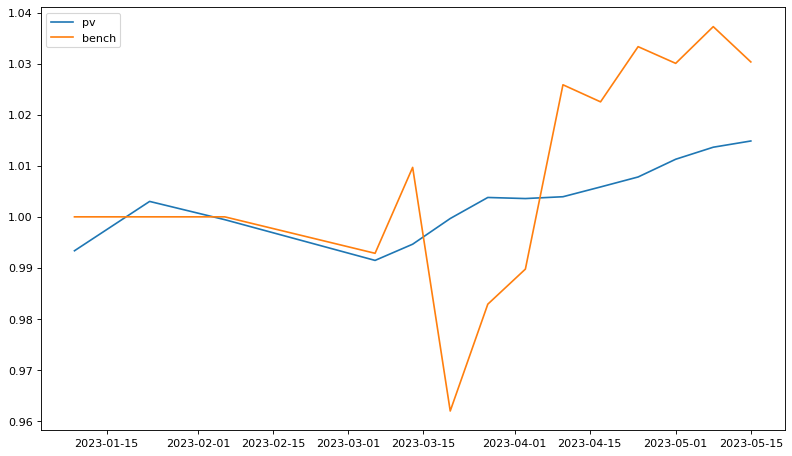

In [42]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [43]:
industry_analysis = ledger.pivot_table(index=["year","week"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x not in  ["year","week"]]].cumprod()

GICS Sector,Communication Services,Health Care,Industrials,Information Technology
0,1.000000,0.971520,0.962078,1.000000
1,1.000000,0.993794,0.962078,1.076730
2,0.998016,0.959807,0.962078,1.076730
3,0.998016,0.935206,0.934857,1.076730
4,0.996754,0.929024,0.922026,1.115868
5,1.054747,0.926643,0.922026,1.115868
6,1.039241,0.926643,0.930531,1.160055
7,1.034724,0.917943,0.935396,1.161031
8,1.034724,0.908388,0.946221,1.163674
9,1.034724,0.924439,0.946221,1.163674
